Based on https://colab.research.google.com/drive/1NvkBmkHfucGO3Ve9s1NKZvMNlw5p83ym?usp=sharing#scrollTo=QmUBVEnvCDJv 

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig, AutoConfig
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import Dataset, DatasetDict

In [2]:
print("Torch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)

Torch version:  2.2.0
CUDA available:  True
CUDA version:  12.1


In [3]:
tokenizer = AutoTokenizer.from_pretrained("unsloth/mistral-7b-v0.3-bnb-4bit")

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  
)

In [5]:
id2label = {0: "Not funny at all", 1: "Not funny", 2: "Neutral", 3: "Funny", 4: "Very funny"}
label2id = {v: k for k, v in id2label.items()}
model = AutoModelForSequenceClassification.from_pretrained("unsloth/mistral-7b-v0.3-bnb-4bit", num_labels=5, id2label=id2label, 
    label2id=label2id)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at unsloth/mistral-7b-v0.3-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=False)

In [7]:
from bitsandbytes.nn import LinearNF4

# Remove the old classifier layer
#del model.score

#config = AutoConfig.from_pretrained("unsloth/Phi-3-mini-4k-instruct")

#fp16_model = nn.Linear(config.hidden_size, 5, bias=False)
#quant_model = LinearNF4(config.hidden_size, 5, bias=False, compute_dtype = torch.float16)


#quant_model.load_state_dict(fp16_model.state_dict())
#quant_model.to('cuda')

# Add a new classifier layer
#model.score = quant_model

#for param in model.score.parameters():
    #param.data = param.data.to(torch.float16).to('cuda')
    #param.requires_grad = True

In [8]:
model

MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096, padding_idx=770)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm):

In [9]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print(f"Inputs: {inputs}")
print(f"Inputs shape: {inputs.shape}")

Inputs: tensor([[   1, 3146, 1136, 1274, 1495]])
Inputs shape: torch.Size([1, 5])


In [10]:
with torch.no_grad():
    outputs = model(inputs)
    logits = outputs.logits
    print(f"Logits: {logits}")
    print(f"Logits shape: {logits.shape}")

Logits: tensor([[0.4294, 2.5692, 1.2930, 2.2260, 2.5403]])
Logits shape: torch.Size([1, 5])


In [11]:
probas = torch.softmax(logits, dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [12]:
# Load the data
data = pd.read_parquet("./humor_classification/data/processed/pretraining_data.parquet")

# Subsample to test the code
data = data.sample(frac=0.025, random_state=42)

# Make all columns objects
data["text"] = data["text"].astype("object")
data["label"] = data["label"].astype(int)


# Split the data
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data["label"])
test, val = train_test_split(test, test_size=0.5, random_state=42, stratify=test["label"])

In [13]:
train.head()

,text,label
245764,20 AMAZING ways to cut down on click bait Well...,4
71459,I sexually identify as a giant.. ..my pronouns...,1
255032,I had to break up with my crossed-eyed girlfri...,4
62293,Jokes about menstrual cycles are not funny. Pe...,1
49181,How did the vacuum cleaner die. It bit the dust.,0


In [14]:
len(train), len(val), len(test)

(5845, 731, 731)

In [15]:
ds = DatasetDict({
    "train": Dataset.from_pandas(train),
    "test": Dataset.from_pandas(test),
    "val": Dataset.from_pandas(val),
})

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length = 256)


tokenized_ds = ds.map(preprocess_function, batched=True)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

Map:   0%|          | 0/5845 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

In [16]:
print(tokenizer.pad_token_id)

770


In [17]:
max_seq_length = 256

In [18]:
config = LoraConfig(
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj", "score"],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = {},
    task_type="SEQ_CLS"
)

model = get_peft_model(model, config)

In [19]:
model.print_trainable_parameters()

trainable params: 168,055,104 || all params: 7,282,143,872 || trainable%: 2.307769620512106


In [20]:
model.config.pad_token_id = tokenizer.pad_token_id

In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}
    
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=4,
    num_train_epochs = 1,
    logging_dir='./logs',
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 4,
    warmup_ratio = 0.03,
    max_grad_norm=0.3,
    learning_rate = 2e-4,
    logging_steps = 1,
    optim = "paged_adamw_32bit",
    weight_decay = 0.001,
    lr_scheduler_type = "constant",
    seed = 3407,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['val'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [22]:
trainin_stats = trainer.train()

Step,Training Loss
1,7.456200
2,7.528100
3,6.739000
4,6.496000
5,4.355800
6,5.394400
7,7.084200
8,5.473800
9,6.075500
10,5.220300


In [24]:
# Save the model
model.save_pretrained("./models/mistral-7b-v0.3-bnb-4bit-finetuned_v.2")

In [22]:
# Evaluate the model
trainer.evaluate(tokenized_ds['test'])

{'eval_loss': 1.6144375801086426,
 'eval_accuracy': 0.2265571526351814,
 'eval_runtime': 361.2367,
 'eval_samples_per_second': 4.044,
 'eval_steps_per_second': 1.013,
 'epoch': 0.27}

In [10]:
tokenized_ds['test'].select(range(10))

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 10
})

In [25]:
# Slice the test dataset to get the first 10 examples
tokenized_ds_10 = tokenized_ds['test'].select(range(500))

# Predict the first 10 examples
preds = trainer.predict(tokenized_ds_10)

# Get the predicted labels
predicted_labels = np.argmax(preds.predictions, axis=-1)

In [26]:
#get acucracy
np.mean(predicted_labels == tokenized_ds_10['label'])


0.212

In [27]:
from sklearn.metrics import classification_report, top_k_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Use the scikit-learn classification report
print(classification_report(true_labels, predictions))

# Use the scikit-learn accuracy score
print(f"Accuracy: {accuracy_score(true_labels, predictions)}")

NameError: name 'true_labels' is not defined

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

                  precision    recall  f1-score   support

Not funny at all       1.00      0.01      0.02       104
       Not funny       0.21      0.99      0.35       104
         Neutral       0.00      0.00      0.00        96
           Funny       0.00      0.00      0.00        96
      Very funny       0.33      0.02      0.04       100

        accuracy                           0.21       500
       macro avg       0.31      0.20      0.08       500
    weighted avg       0.32      0.21      0.08       500

Top 2 accuracy:  0.456
Accuracy:  0.212


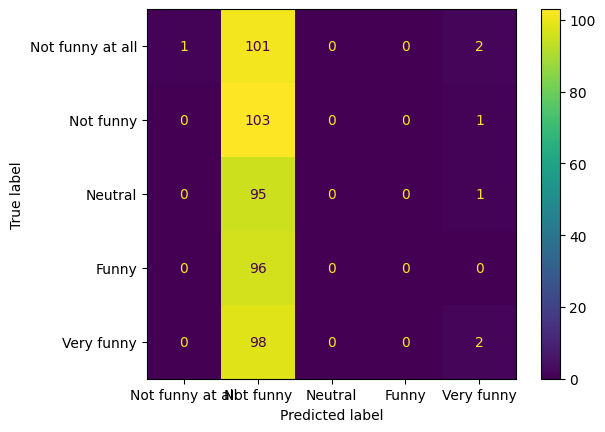

In [30]:
#Top 2 predictions
from sklearn.metrics import classification_report, top_k_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(preds.label_ids, preds.predictions.argmax(axis=1), target_names=id2label.values()))

print("Top 2 accuracy: ", top_k_accuracy_score(preds.label_ids, preds.predictions, k=2))
print("Accuracy: ", accuracy_score(preds.label_ids, preds.predictions.argmax(axis=1)))

cm = confusion_matrix(preds.label_ids, preds.predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot()

In [9]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce GTX 1660 Ti. Max memory = 6.0 GB.
2.283 GB of memory reserved.
